# Combining verification results

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import score_utils as su

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### Load config

In [3]:
config_name = os.path.realpath('verif_config.yml')

with open(config_name, 'r') as stream:
    conf = conf = yaml.safe_load(stream)

## SEEPS

In [4]:
model_names = ['fuxi_physics', 'fuxi_mlevel_physics', 'fuxi_mlevel_dry']
IND_max = 1462
INDs = np.arange(0, IND_max+50, 50)
INDs[-1] = IND_max

In [5]:
VERIF = {}

for model_name in model_names:
    # file names to load
    base_dir = conf[model_name]['save_loc_verif']
    
    verif_lead_range = conf[model_name]['verif_lead_range']
    path_IMERG_verif = base_dir + 'combined_IMERG_{:04d}_{:04d}_{:03d}h_{:03d}h_{}.nc'
    
    # file names to save
    path_IMERG_save = base_dir + 'IMERG_{:03d}h_{:03d}h_{}.nc'
    
    # load xarray.Dataset and merge all verified days
    IMERG_verif = []
    
    for i, ind_start in enumerate(INDs[:-1]):
        ind_end = INDs[i+1]
        filename = path_IMERG_verif.format(
            ind_start, ind_end, verif_lead_range[0], verif_lead_range[-1], model_name)
        
        ds_verf_temp = xr.open_dataset(filename)
        IMERG_verif.append(ds_verf_temp)
    
    # merge by concat
    ds_IMERG_verif = xr.concat(IMERG_verif, dim='days')
    
    # save to one dictionary for some checking
    VERIF['{}_IMERG'.format(model_name)] = ds_IMERG_verif
    
    # save to nc
    save_name_IMERG = path_IMERG_save.format(verif_lead_range[0], verif_lead_range[-1], model_name)
    # not over-write
    try:
        ds_IMERG_verif.to_netcdf(save_name_IMERG, mode='w')
    except:
        print('the file exists')
        pass
    print('Save to {}'.format(save_name_IMERG))

Save to /glade/campaign/cisl/aiml/ksha/CREDIT_cp/VERIF/fuxi_w_physics2/IMERG_006h_360h_fuxi_physics.nc
Save to /glade/campaign/cisl/aiml/ksha/CREDIT_cp/VERIF/fuxi_mlevel_physics2/IMERG_006h_360h_fuxi_mlevel_physics.nc
Save to /glade/campaign/cisl/aiml/ksha/CREDIT_cp/VERIF/fuxi_mlevel_dry2/IMERG_006h_360h_fuxi_mlevel_dry.nc


In [6]:
verif_dir = '/glade/campaign/cisl/aiml/ksha/CREDIT_cp/VERIF/'

In [7]:
ds_plevel_phy = xr.open_dataset(verif_dir+'fuxi_w_physics2/IMERG_006h_360h_fuxi_physics.nc')
ds_mlevel_phy = xr.open_dataset(verif_dir+'fuxi_mlevel_physics2/IMERG_006h_360h_fuxi_mlevel_physics.nc')
ds_mlevel_dry = xr.open_dataset(verif_dir+'fuxi_mlevel_dry2/IMERG_006h_360h_fuxi_mlevel_dry.nc')
ds_IFS = xr.open_dataset('/glade/campaign/cisl/aiml/ksha/CREDIT_physics/VERIF/IFS/IMERG_006h_240h_IFS.nc')

seeps_plevel_phy = ds_plevel_phy['total_precipitation'].values.mean(axis=0)
seeps_mlevel_phy = ds_mlevel_phy['total_precipitation'].values.mean(axis=0)
seeps_mlevel_dry = ds_mlevel_dry['total_precipitation'].values.mean(axis=0)
seeps_IFS = ds_IFS['total_precipitation'].values.mean(axis=0)

In [8]:
PLOT_data = {}
PLOT_data['IMERG_IFS'] = seeps_IFS
PLOT_data['IMERG_plevel_phy'] = seeps_plevel_phy
PLOT_data['IMERG_mlevel_dry'] = seeps_mlevel_dry
PLOT_data['IMERG_mlevel_phy'] = seeps_mlevel_phy
# np.save('/glade/campaign/cisl/aiml/ksha/CREDIT_cp/PLOT_data/SEEPS_IMERG_2020_2021.npy', PLOT_data)

## TS scores

In [9]:
model_names = ['IFS', 'fuxi_physics', 'fuxi_mlevel_physics', 'fuxi_mlevel_dry']

In [10]:
list_thres = 1e-3*np.array([0.1, 0.25, 0.5, 1, 2, 3, 4, 5, 7, 10, 15, 20, 25,])
dict_save = {}

for model_name in model_names:
    result_ = np.empty((10, len(list_thres), 3)) # 1st col = all grids; 2nd col = land grids
    # file names to load
    base_dir = conf[model_name]['save_loc_verif']
    names_npy = sorted(glob(base_dir + 'combined_TS_*d_*npy'))
    for i_fn, fn in enumerate(names_npy[:10]):
        TS_ = np.load(fn)
        result_[i_fn, ...] = TS_[:13]
        
    dict_save[model_name] = result_

In [11]:
# # Save
# np.save('/glade/campaign/cisl/aiml/ksha/CREDIT_cp/PLOT_data/TS_IMERG_2020_2021.npy', dict_save)

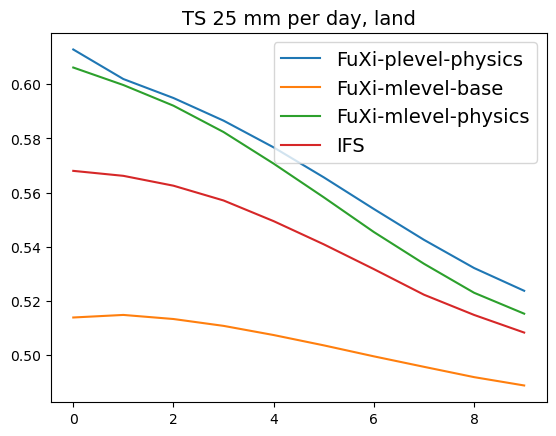

In [12]:
i_thres = 0
i_land = 0

plt.plot(dict_save['fuxi_physics'][:, i_thres, i_land], label='FuXi-plevel-physics')
plt.plot(dict_save['fuxi_mlevel_dry'][:, i_thres, i_land], label='FuXi-mlevel-base')
plt.plot(dict_save['fuxi_mlevel_physics'][:, i_thres, i_land], label='FuXi-mlevel-physics')
plt.plot(dict_save['IFS'][:, i_thres, i_land], label='IFS')
plt.title('TS 25 mm per day, land', fontsize=14)
plt.legend(fontsize=14)